**Final project CIS 5570 - Emotion Sentiment analysis of social comments**

Multiclass and Multilabel classification problem

Group 3: Deepthi Arcot, Meghanath Payasam, Sreeja Narahari, Sowmya Ramanujam, Tanvi Shah


In [4]:
!pip install -q pyspark
!pip install nltk
!pip install symspellpy
!pip install setuptools
!pip install spacy

# Downloading the GoEmotions dataset consisting of 200000+ reddit comments prepared by Google and humanly annotated for 28 human emotions
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv -O 'goemo1.csv'
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv -O 'goemo2.csv'
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv -O 'goemo3.csv'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.3-cp39-cp39-linux_x86_64.whl size=141214 sha256=94b0f0d592d3f68734f72a199a3ca94e0b9189e739d21e89383efaa2cd1511e8
  Stored in directory: /root/.cache/pip/wheels/72/16/b1/ea6472dedd6ac13ad789dd294871a76fd6906fca3c010347d1
Successfully built editdistpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

# Brief approach: We are attempting both Multiclass unilabel classification and Multiclass Multilabel multioutput classification

a. Using pyspark, analysed the GoEmotions dataset, cleaned the data and preprocessed it suitable for text mining (cleaning the labels data, removing duplicate entries,removing numbers, removing HTML tags, Decontraction of words, Removing punctuations and special characters, Spelling correction using symspellpy, Removing stopwords usign a custom list, stemming)
b. the processed RDD, is converted to pyspark DF.
c. Feature extraction from text and conversion to numerical vector done by two approaches i) TF-IDF of 1 to 5 grams of text using pyspark ml libraries- to extract sequence information from text ii) Word2vec feature extraction to gain contextual understanding of text- using pyspark ml lib
d.Label transformed to a vector
e. Following ML techniques explored via pyspark ml lib - Multinomial regression using TF-IDF 1-5gram, Multinomial regression using Word2vec feature. we also explored One vs Rest Multinomial 
f. Deep learning LSTM technique explored through Python scikit



---



In [186]:
from pyspark.sql.functions import lit
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import count,sum, col, when, concat_ws, expr, concat
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import pkg_resources
from symspellpy import SymSpell, Verbosity #for spelling correction
from nltk.stem import SnowballStemmer #snowball stemming for stemming operations.
from pyspark.ml.feature import NGram, HashingTF, IDF, Word2Vec,CountVectorizer,VectorAssembler,UnivariateFeatureSelector
from pyspark.ml import Pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [187]:
conf = SparkConf().setAppName('Sparkproject_group3')
sc = SparkContext.getOrCreate(conf = conf)

spark = SparkSession.builder.master("local[1]")\
          .appName("Sparkfinalproject")\
          .getOrCreate()

In [188]:
"""0.Reading the dataset as a pyspark dataframe"""

path = ['goemo1.csv','goemo2.csv','goemo3.csv'] 
df_emo=spark.read.csv(path,header=True) 

#the dataset has several attributes, we retain just the column named 'Text' which contains text reddit comments , annotated with a vector of emotions coded 0 or 1
df_emo=df_emo.drop('id','author','subreddit','link_id','parent_id','created_utc','rater_id','example_very_unclear')

print("sample row of data: ",df_emo.head())
print("Total count of rows: ",df_emo.count())

sample row of data:  Row(text="Worst ending ever! I won't spoil it but this one sucked worse than the avengers last movie!", admiration='0', amusement='0', anger='0', annoyance='0', approval='0', caring='0', confusion='0', curiosity='0', desire='0', disappointment='1', disapproval='0', disgust='0', embarrassment='0', excitement='0', fear='0', gratitude='0', grief='0', joy='0', love='0', nervousness='0', optimism='0', pride='0', realization='0', relief='0', remorse='0', sadness='0', surprise='0', neutral='0')
Total count of rows:  211225


In [189]:
#Exploratory data analysis and preparing data for preprocessing

#Creating a list of emotions from the dataset. Emotions are the columns in the dataset
emotion_cols=df_emo.schema.names[-28:]

"""1. The values in the emotions field should be 1 or 0, if any other characters occur- to clean the data appropriately"""
def data_check(df):
  df.select(*(sum(c) for c in emotion_cols)).show()
  for i in emotion_cols:
    df.select(col(i)).distinct().show() 
    
#data_check(df_emo) - Shows presence of special values in emotion tags 'admiration', 'amusement','anger' and'annoyance'-contains some entries labelled 'False' and some numbers >1 and some alphanumeric characters

for i in ['admiration','amusement','anger','annoyance']:
  df_emo=df_emo.withColumn(i,
                           when(df_emo[i]>0,1)
                           .when(df_emo[i].isin(['False','false']),0)
                           .when(df_emo[i].isin(['True','true']),1)
                           .otherwise(0))
   
"""2. Comments manually annotated for emotion tags by multiple users, which is causing duplicate entires- 
To group the comment, consolidate the emotion tagging and then drop duplicate entries"""
 
df_grouped = df_emo.groupBy('text').agg(
    sum('admiration').alias('admiration'),
    sum('amusement').alias('amusement'),
    sum('anger').alias('anger'),
    sum('annoyance').alias('annoyance'),
    sum('approval').alias('approval'),
    sum('caring').alias('caring'),
    sum('confusion').alias('confusion'),
    sum('curiosity').alias('curiosity'),
    sum('desire').alias('desire'),
    sum('disappointment').alias('disappointment'),
    sum('disapproval').alias('disapproval'),
    sum('disgust').alias('disgust'),
    sum('embarrassment').alias('embarrassment'),
    sum('excitement').alias('excitement'),
    sum('fear').alias('fear'),
    sum('gratitude').alias('gratitude'),
    sum('grief').alias('grief'),
    sum('joy').alias('joy'),
    sum('love').alias('love'),
    sum('nervousness').alias('nervousness'),
    sum('optimism').alias('optimism'),
    sum('pride').alias('pride'),
    sum('realization').alias('realization'),
    sum('relief').alias('relief'),
    sum('remorse').alias('remorse'),
    sum('sadness').alias('sadness'),
    sum('surprise').alias('surprise'),
    sum('neutral').alias('neutral'))

#drop duplicate entries of comments, if any
df_unique_comments = df_grouped.dropDuplicates(['text'])

#convert all >1 values in emotion tags to 1, and retain the 0s
for column in df_unique_comments.columns[1:]:
    df_unique_comments = df_unique_comments.withColumn(column, when(col(column) > 0, 1).otherwise(0))

"""3. Adding another column called 'Emotions' to extract the text emotion from the vector"""

df_emo_text=df_unique_comments.withColumn("emotions", concat_ws(',',*[when(df_unique_comments[i]==1,i) for i in emotion_cols]))
df_emo_tclean = df_emo_text.filter(df_emo_text['emotions'] != " ")

print("total count of unique texts: ",df_emo_tclean.count())



total count of unique texts:  57729


Total count of comments:  57729
+---------------+--------------+----------+--------------+-------------+-----------+--------------+--------------+-----------+-------------------+----------------+------------+------------------+---------------+---------+--------------+----------+--------+---------+----------------+-------------+----------+----------------+-----------+------------+------------+-------------+------------+
|sum(admiration)|sum(amusement)|sum(anger)|sum(annoyance)|sum(approval)|sum(caring)|sum(confusion)|sum(curiosity)|sum(desire)|sum(disappointment)|sum(disapproval)|sum(disgust)|sum(embarrassment)|sum(excitement)|sum(fear)|sum(gratitude)|sum(grief)|sum(joy)|sum(love)|sum(nervousness)|sum(optimism)|sum(pride)|sum(realization)|sum(relief)|sum(remorse)|sum(sadness)|sum(surprise)|sum(neutral)|
+---------------+--------------+----------+--------------+-------------+-----------+--------------+--------------+-----------+-------------------+----------------+------------+----------

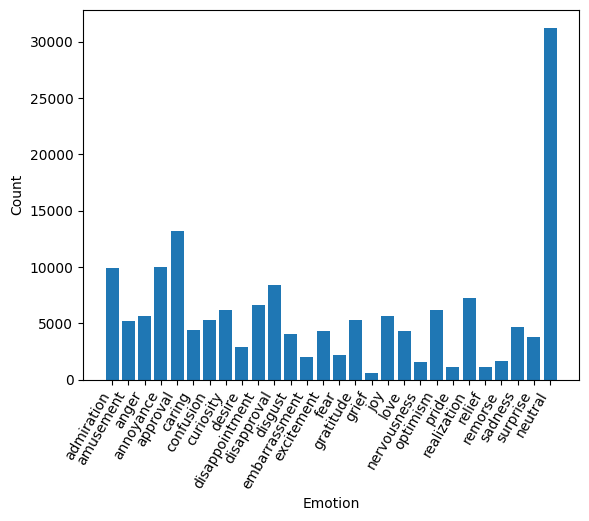

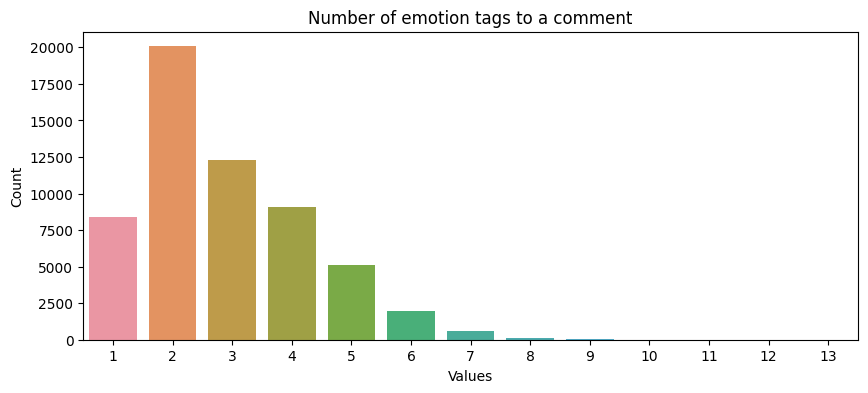

Cleaning the dataframe to include only four emotion tags per comment, sample comments and emotions
+-----------------------------------------------------------------------------------------------------------------------------------------+----------------------------+
|text                                                                                                                                     |emotions_4                  |
+-----------------------------------------------------------------------------------------------------------------------------------------+----------------------------+
|Yesterday. All my troubles seemed so faaar away. Now it looks though that they're here to stay. Oh I believe, in yesterday.              |optimism,relief,neutral     |
|The anniversary march was held in Derry Sunday past , not one mention on BBC itv not a thing. 14 people murdered in cold blood. Nothing. |anger,approval,grief,sadness|
|..... sigh.... gross                                   

In [191]:
"""4. Analyzing emotion tags per comment and the overall emotion distribution to understand how balanced the dataset is.
Actions taken basis analysis: Retaining 4 emotions per tag as the objective is to identify the core emotion of a text 
and also to avoid 'neutral' tagging skew to a comment """

##Analyzing tags per emotion 
print("Total count of comments: ",df_emo_tclean.count())

data = df_emo_tclean.select(*(sum(c) for c in emotion_cols)).toPandas()
df_emo_tclean.select(*(sum(c) for c in emotion_cols)).show()

counts = data.values.tolist()[0]
fig, ax = plt.subplots()
ax.bar(emotion_cols,counts)
ax.set_xlabel('Emotion')
ax.set_ylabel('Count')
plt.xticks(rotation=60, ha='right')
plt.show() 


## number of tags per comments- to understand the dataset distribution
df_pandas= df_emo_tclean.toPandas()
df_pandas["emote_count"] = df_pandas["emotions"].apply(lambda text: len(str(text).split(",")))
df_pandas.head()

plt.figure(figsize=(10, 4))
sns.countplot(x='emote_count', data=df_pandas)
plt.title("Number of emotion tags to a comment")
plt.xlabel('Values')
plt.ylabel('Count')
plt.show()


#the first graph shows a heavy tilt towards neutral tagging for a emotion. almost half of the comments have a 'neutral' tagging along with other tags.
#Remember majority of the comments have >1 emotion tagged. 
#We are retaining first four emotions for every comment, to avoid 'heavy neutral' classification. 
#Also we may dilute the objective of identifying the core emotions of a text, if we describe a text with more than 4 emotions.

from pyspark.sql.functions import split, exp, size
df_emo_clean = df_emo_tclean.withColumn("emotions_list", split("emotions", ","))
df_emo_clean = df_emo_clean.withColumn("emotions_list", expr("filter(emotions_list, x -> length(trim(x)) > 0)"))
df_emo_clean = df_emo_clean.withColumn("emotions_4", when(size("emotions_list") >= 4, expr("emotions_list[0] || ',' || emotions_list[1] || ',' || emotions_list[2] || ',' || emotions_list[3]")).otherwise(df_emo_clean.emotions))
clean_df_emo = df_emo_clean.drop("emotions_list")
clean_df = clean_df_emo.select("text", "emotions_4")
print("Cleaning the dataframe to include only four emotion tags per comment, sample comments and emotions")
clean_df.show(5, truncate=False)



---


Pre Processing

In [192]:
"""5.Converting from Pyspark DF to Pyspark RDD to carry out text preprocessing steps"""
# We can work on Pyspark dataframe also

rdd_emote=clean_df.rdd.map(lambda x:(x[0],x[1])) # We will use this as a master RDD for all preprocessing 


In [193]:
"""6.Preprocessing text prior to feature extraction"""

snowstemmer = SnowballStemmer('english') 
nlp = spacy.load('en_core_web_sm') #for lemmatization

#Words decontraction -Building a dictionary of commonly used sentence contractions. Note: We have considered the textual writing aspect here. 'can't' and 'cant' both will be decontracted to 'cannot'. 
#While writing (unless a formal writing) many writers miss the apostrophes for certain words in social writing. In summary we are adjusting our model to suit the writing styles of today.
#We also quickly examined the lingo of the comments and used certain urban abbreviations like 'lol','omg','haha'- as these are cues for emotions as well.

decontraction_dict = {
    "ain't": "is not", "aint": "is not", "amn't": "am not","aren't": "are not","arent": "are not","can't": "cannot","cant": "cannot","'cause": "because","cos":"because","could've": "could have","couldn't": "could not","couldnt": "could not","couldn": "could not",\
    "didn't": "did not","didnt": "did not","doesn't": "does not","doesnt": "does not","don't": "do not","dont": "do not","hadn't": "had not","hadnt": "had not","hasn't": "has not","hasnt": "has not","haven't": "have not","havent": "have not",
    "he'd": "he would","he'll": "he will","he's": "he is","hed": "he would","hes": "he is","how'd": "how did","how'll": "how will","how're": "how are","how's": "how is","howd": "how did","howll": "how will","howre": "how are","hows": "how is",
    "I'd": "I would","I'll": "I will","I'm": "I am","I've": "I have","im": "I am","ive": "I have", "isn't": "is not","isnt": "is not","it'd": "it would","it'll": "it will","it's": "it is","itd": "it would","itll": "it will","let's": "let us",
    "lets": "let us","ma'am": "madam", "mam":"madam","might've": "might have", "mightve": "might have","mightnt": "might not","mightn't": "might not","must've": "must have", "mustn't": "must not","mustnt": "must not","needn't": "need not",
    "neednt": "need not", "o'clock": "of the clock", "oughtn't": "ought not", "oughtnt": "ought not", "shan't": "shall not", "shant": "shall not", "she'd": "she would", "she'll": "she will", "she's": "she is", "shes": "she is", "should've": "should have",
    "shouldn't": "should not", "shouldnt": "should not","shouldn":"should not", "somebody's": "somebody is", "someones": "someone is", "something's": "something is", "thats": "that is", "that's":"that is","thered": "there would", "they'd": "they would","they'll": "they will","they're": "they are",
    "they've": "they have","wasn't": "was not","wasnt": "was not","we'd": "we would","we'll": "we will","we're": "we are","we've": "we have","weren't": "were not","werent": "were not","what'll": "what will","what're": "what are","what's": "what is","what've": "what have",
    "whats": "what is","where's": "where is","wheres": "where is","who'd": "who would","who'll": "who will","who're": "who are","who's": "who is","who've": "who have","whod": "who would","whos": "who is","why'd": "why did","why'll": "why will",
    "why're": "why are","why's": "why is","won't": "will not","wont": "will not","would've": "would have","wouldn't": "would not","wouldnt": "would not","wouldn": "would not","you'd": "you would","you'll": "you will","you're": "you are","you've": "you have","youd": "you would","youll": "you will",
    "youre": "you are","youve": "you have", "gonna":"going to","wanna": "want to","lol":"laugh out loud",":)":"smile",":(":"sad","ROFL":"rolling on the floor laughing","gotta":"going to","idk":"i do not know","haha":"laughing","hahaha":"laughing","oof":"sigh","uff":"sigh","omg":"oh my god"}

#Stopwords list dictionary
stopwords_list = stopwords.words('english') #downloading nltk stopwords list
retain_words=['no','not','nor','but','very','can','will','do','should','could', "would", 'none','what','which','but','yet','however','if','only','because', 'against','how','more','too','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'they', 'them', 'their', 'theirs', 'themselves', 'very']
for item in retain_words:
  if item in stopwords_list:
    stopwords_list.remove(item) # creating a custom stopwords list by removing some words of interest from nltk list
    stopwords_bc=sc.broadcast(stopwords_list) #broadcasting the custom stopwords list to all RDD partitions, has 131 words

#removing word numbers-list
number_words = ['zero', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty','dozen']

## All basic processing steps of the text.
def preprocessing(line): 
  processed=[]
  new_word=str()
  line = re.sub("\S*\d\S*", "", line).strip() #strips numbers
  text = re.sub(r"http\S+", "", line) #strips URL/HTML tags
  line = re.sub(r"www.\S+", "", text) #strips URL tags
  words = line.split() #splitting the words
  for word in words:
    word=word.strip("., ") 
    if word in decontraction_dict:
        word = decontraction_dict[word] #Decontracting words using the dict look up above
    wor = re.sub(r"(.)\1{2,}", r"\1", word) #tackles elongated words eg: 'boringgg' to 'boring' , 'looove' to 'love'
    word = wor.strip(string.punctuation) #stripping punctuation marks
    word = word.strip(" ") #removing all whitespaces
    if (word not in stopwords_bc.value) and (word not in number_words): # removing stopwords from a custom stopwords list created above
      processed.append(word)
  processed_line=" ".join(processed) 
  processed_line = re.sub(r'[^\w\s]', '', processed_line)  #removing any other special characters
  return processed_line

#Spellingcorrection. Using a dictionary based word correction approach via computationally light Symspell. It is not perfect always, but close. During our testing, we found Pyspellchecker to be the best as it uses statistical approach, but computationally very intensive.
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
def correct_spelling(line):
  corrected_words=[]
  for word in line.split():
    suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
    if suggestions:
      corrected_words.append(suggestions[0].term)
    else:
      corrected_words.append(word)
  corrected_text = ' '.join(corrected_words)
  return corrected_text

# optional-snowball stemming to convert words to root word.optional step before Tf-idf vectorization. Helps to keep the vector sparse.
def snow_stemming(line):
  new_words=[]
  for cleaned_words in line.split():
      stemmed_word=(snowstemmer.stem(cleaned_words))                                   
      new_words.append(stemmed_word)
  new_sentence=" ".join(new_words)
  return new_sentence

#optional- lemmatization using spacy
def lemmatization(line):
  doc = nlp(line)
  lemmatized_words = [word.lemma_ for word in doc]
  return (' '.join(lemmatized_words))

def clean_tags(line):
  m=[]
  for x in line:
    if len(x)>0:
      x=x.strip(" ")
      m.append(x)
  return m


"""5.Combining all of the techniques to do preprocessing of the RDD text"""

rdd_processed_notstemmed_1=rdd_emote.map(lambda x:(preprocessing(x[0].lower()),x[1]))
rdd_processed_notstemmed=rdd_processed_notstemmed_1.map(lambda x: (x[0].split(),x[1]))
rdd_multilabel=rdd_processed_notstemmed.map(lambda x: (x[0],clean_tags(x[1].split(","))))


rdd_processed_stemmed=rdd_emote.map(lambda x:(snow_stemming(preprocessing(x[0].lower())),x[1])).map(lambda x: (x[0].split(),clean_tags(x[1].split(","))))
rdd_multiclass_singlelabel=rdd_processed_stemmed.map(lambda x:(x[0],"".join(x[1][:1])))

In [196]:
#Converting RDD to DF suitable for further operations
from pyspark.sql.functions import monotonically_increasing_id

#Preparing dataframe for multilabel multioutput classification, upto four emotions are considered for each comment
processed_df_1=  rdd_multilabel.toDF(["comments_text","emotion_tags"])
processed_df = processed_df_1.withColumn("index_column",monotonically_increasing_id())
processed_df = processed_df.select("index_column", "comments_text","emotion_tags")

#preparing dataframe for multiclass single output classification, one emotion  is considered for the comment
Processed_df_multiclass=rdd_multiclass_singlelabel.toDF(["comments_text","emotion_tags"])
Processed_df_multiclass = Processed_df_multiclass.withColumn("index_column",monotonically_increasing_id())
Processed_df_multiclass = Processed_df_multiclass.select("index_column", "comments_text","emotion_tags")




---


Feature extraction and vectorization - using pyspark ML libraries

In [197]:
"""Using Pyspark ML lib for feature extraction and featurization of text data"""
from pyspark.ml.feature import StringIndexer

#1a.Labels transformed to binary vector (sparse vector) for a multilabel problem
cv = CountVectorizer(inputCol="emotion_tags", outputCol="labels")
cv_model = cv.fit(processed_df)
processed_df_withyvector = cv_model.transform(processed_df).select("index_column","comments_text", "emotion_tags","labels")
#vocab = cv_model.vocabulary #- use this to see the y label indexes


##1b Labels tranformed to numerical labels for a multiclass unioutput problem
indexer = StringIndexer(inputCol="emotion_tags", outputCol="labels")
model = indexer.fit(Processed_df_multiclass)
df_indexed = model.transform(Processed_df_multiclass).select("index_column","comments_text", "emotion_tags","labels")


In [198]:
## 2.Splitting data into Train and Test data
from pyspark import StorageLevel
processed_df_withyvector.persist(StorageLevel.MEMORY_AND_DISK)   #caching the Dataframe to allow close to consistent distribution of train and test each time
df_indexed.persist(StorageLevel.MEMORY_AND_DISK)

#multiclass multilabel data
train_data, test_data = processed_df_withyvector.randomSplit(weights=[0.75, 0.25],seed=256)  #only the y label has been featurized at this stage and preprocessing done
#train_data.show(20,truncate=False)

#multiclass unilabel data
train_data_multiclass, test_data_multiclass =df_indexed.randomSplit(weights=[0.75, 0.25],seed=1256)

In [201]:
###3a. first approach -Feature extraction and vectorization using n-grams, Tf.IDf - to extract information out of word sequences and frequency of occurrence
from pyspark.ml.feature import NGram, HashingTF, IDF, Word2Vec,CountVectorizer,VectorAssembler,UnivariateFeatureSelector
from pyspark.ml import Pipeline

def build_ngrams_tfidf(inputCol=["comments_text"], n=5):
    ngrams = [NGram(n=i, inputCol="comments_text", outputCol="{0}_grams".format(i)) for i in range (1,n+1)]
    termfreq_cv = [CountVectorizer(inputCol="{0}_grams".format(i),outputCol="{0}_termfreq".format(i),minDF=5) for i in range (1,n+1)]
    idf = [IDF(inputCol="{0}_termfreq".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=3) for i in range (1,n+1)]
    assembler = [VectorAssembler(inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],outputCol="tfidf_feature")]
    return Pipeline(stages=ngrams + termfreq_cv + idf + assembler)

#Fitting tfidf on multiclass multilabel train data
x_train_tfidfvectorized=build_ngrams_tfidf().fit(train_data)
train_tfidf=x_train_tfidfvectorized.transform(train_data)
train_tfidf_final=train_tfidf.select("tfidf_feature","labels")
#train_tfidf_final.show(5) ##shown only for the purpose of report, commented out in actual file

# fitting tfidf  on multiclass, unilabel train data
mc_train_tfidf_model =build_ngrams_tfidf().fit(train_data_multiclass)
mc_train_tfidf=mc_train_tfidf_model.transform(train_data_multiclass)
mc_train_tfidf=mc_train_tfidf.select("tfidf_feature","labels")
#mc_train_tfidf.show(5)


In [202]:
###3b. Second approach -Feature extraction and vectorization using unigram-Word2Vec- to extract semantic relationship between the words

w2v = Word2Vec(vectorSize=50,seed=42, minCount=0, inputCol="comments_text", outputCol="word2Vec_feature", numPartitions=5,maxIter=4)

#fitting word2vec on multilabel train data
train_w2v = w2v.fit(train_data)
train_w2v_df=train_w2v.transform(train_data)   #or use getVectors if you want unique mappings
train_w2v_final=train_w2v_df.select("index_column","comments_text","word2Vec_feature","emotion_tags","labels")
#train_w2v_final.show(2)

#fitting word2vec on multiclass train data
mc_train_w2v = w2v.fit(train_data_multiclass)
mc_train_w2v_df=mc_train_w2v.transform(train_data_multiclass)   #or use getVectors if you want unique mappings
mc_train_w2v_final=mc_train_w2v_df.select("index_column","comments_text","word2Vec_feature","emotion_tags","labels")
#mc_train_w2v_final.show(2)


In [203]:
#Preparing test featurizations 

#a)using trained models for tfidf and word2vec (this is to avoid any dataleakage)
mc_test_tfidf=mc_train_tfidf_model.transform(test_data_multiclass)
mc_test_w2v=mc_train_w2v.transform(test_data_multiclass)

#b)using a fresh Tfidf and word2vec of the test data
mc_test_tfidf_2=build_ngrams_tfidf().fit(test_data_multiclass).transform(test_data_multiclass).select("tfidf_feature","labels")

w2v = Word2Vec(vectorSize=50,seed=42, minCount=0, inputCol="comments_text", outputCol="word2Vec_feature", numPartitions=5,maxIter=4)
mc_test_w2v_2=w2v.fit(test_data_multiclass).transform(test_data_multiclass).select("word2Vec_feature","labels")

Machine learning algorithms using Pyspark libraries

In [204]:
### 4. Performing multinomial logistic regression (softmax) regression- using Pyspark ML lib- multiclass single label

#Baseline model
from pyspark.ml.classification import LogisticRegression,OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## fitting a tf-idf 1-5 grams featurized model with multinomial logistic regression

#a
lr1 = LogisticRegression(featuresCol="tfidf_feature",labelCol="labels",maxIter=10,regParam=0.1, elasticNetParam=0.25, fitIntercept=True, family='multinomial')
lrModel_tfidf_1 = lr1.fit(mc_train_tfidf)

predictions_1 = lrModel_tfidf_1.transform(mc_test_tfidf)

evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy_1 = evaluator.evaluate(predictions_1)
print("accuracy with tf-idf 5-gram, lambda =0.1, alpha=0.25 ", accuracy_1)

#b
lr2 = LogisticRegression(featuresCol="tfidf_feature",labelCol="labels",maxIter=100,regParam=0.01, elasticNetParam=0.4, fitIntercept=True, family='multinomial')
lrModel_tfidf_2 = lr2.fit(mc_train_tfidf)

predictions_2 = lrModel_tfidf_2.transform(mc_test_tfidf)

evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy_2 = evaluator.evaluate(predictions_2)
print("accuracy with tf-idf 5-gram, lambda =0.01, alpha=0.4, Iter=100", accuracy_2)

#c
lr3 = LogisticRegression(featuresCol="tfidf_feature",labelCol="labels",maxIter=200,regParam=0.008, elasticNetParam=0.8, fitIntercept=True, family='multinomial')
lrModel_tfidf_3 = lr3.fit(mc_train_tfidf)

predictions_3 = lrModel_tfidf_3.transform(mc_test_tfidf)

evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy_3 = evaluator.evaluate(predictions_3)
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions_3)

print("accuracy with tf-idf 5-gram, lambda =0.008, alpha=0.8, Iter=200 ", accuracy_3 )
print("F1_score with tf-idf 5-gram, lambda =0.008, alpha=0.8, Iter=200 ", f1_score )


accuracy with tf-idf 5-gram, lambda =0.1, alpha=0.25  0.2497918401332223
accuracy with tf-idf 5-gram, lambda =0.01, alpha=0.4, Iter=100 0.3841243408270885
accuracy with tf-idf 5-gram, lambda =0.008, alpha=0.8, Iter=200  0.3680960310852068
F1_score with tf-idf 5-gram, lambda =0.008, alpha=0.8, Iter=200  0.3343606109287408


In [205]:
###performing Multinomial logistic regression with word2vec feature vector - multiclass single label problem
#with word2Vec

lr_w2v_1 = LogisticRegression(featuresCol="word2Vec_feature",labelCol="labels",maxIter=10,regParam=0.1, elasticNetParam=0.25, fitIntercept=True, family='multinomial')

lrModel_w2v = lr_w2v_1.fit(mc_train_w2v_final)
predictions = lrModel_w2v.transform(mc_test_w2v)

evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)

print("accuracy with w2v, lambda =0.1, alpha=0.25, Iter=10", accuracy)
print("F1 score with w2v, lambda =0.1, alpha=0.25, Iter=10", f1_score)


lr_w2v_1 = LogisticRegression(featuresCol="word2Vec_feature",labelCol="labels",maxIter=100,regParam=0.01, elasticNetParam=0.5, fitIntercept=True, family='multinomial')

lrModel_w2v = lr_w2v_1.fit(mc_train_w2v_final)
predictions = lrModel_w2v.transform(mc_test_w2v)

evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)

print("accuracy with w2v, lambda =0.01, alpha=0.5, Iter=100", accuracy)
print("F1 score with w2v, lambda =0.01, alpha=0.5, Iter=100", f1_score)

lr_w2v_1 = LogisticRegression(featuresCol="word2Vec_feature",labelCol="labels",maxIter=500,regParam=0.005, elasticNetParam=0.55, fitIntercept=True, family='multinomial')

lrModel_w2v = lr_w2v_1.fit(mc_train_w2v_final)
predictions = lrModel_w2v.transform(mc_test_w2v)

evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)

print("accuracy with w2v, lambda =0.008, alpha=0.6, Iter=500", accuracy)
print("F1 score with w2v, lambda =0.008, alpha=0.6, Iter=500", f1_score)

accuracy with w2v, lambda =0.1, alpha=0.25, Iter=10 0.2243269497640855
F1 score with w2v, lambda =0.1, alpha=0.25, Iter=10 0.12686254052479973
accuracy with w2v, lambda =0.01, alpha=0.5, Iter=100 0.27692200943658063
F1 score with w2v, lambda =0.01, alpha=0.5, Iter=100 0.21500303023337713
accuracy with w2v, lambda =0.008, alpha=0.6, Iter=500 0.28677490979739106
F1 score with w2v, lambda =0.008, alpha=0.6, Iter=500 0.23562430637839293




---



Machine learning algorithms- multioutput algorithms in Python, scikit

In [2]:
import pandas as pd
#importing sklearn packages for reference SVM, Naive Bayes ML models. 
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.utils.np_utils import to_categorical

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import f1_score
import numpy as np




In [3]:
#As pyspark ml libraries do not support multioutput Ml algos yet, we tried python
processed_df_ml=rdd_processed_notstemmed_1.toDF(["comments_text","emotion_tags"])
processed_df=processed_df_ml.toPandas()
processed_df=processed_df.sample(frac=0.5, random_state=143)
X = processed_df['comments_text']
y = processed_df['emotion_tags']
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X, y, test_size=0.2, random_state=42)


NameError: ignored

In [1]:
""" LSTM - Optimal model with good accuracy"""

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_LSTM)
X_train_LSTM = tokenizer.texts_to_sequences(X_train_LSTM)
X_test_LSTM = tokenizer.texts_to_sequences(X_test_LSTM)

# Pad the sequences with zeros so that all sequences have the same length
max_length = max([len(seq) for seq in X_train_LSTM])
X_train_LSTM = pad_sequences(X_train_LSTM, maxlen=max_length, padding='post')
X_test_LSTM = pad_sequences(X_test_LSTM, maxlen=max_length, padding='post')

encode = MultiLabelBinarizer()
y_train_LSTM = encode.fit_transform(y_train_LSTM)
y_test_LSTM = encode.fit_transform(y_test_LSTM)

# Build the LSTM model
LSTM_model = Sequential()
LSTM_model.add(Embedding(5000, 128, input_length=max_length))
LSTM_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
LSTM_model.add(Dense(23, activation='softmax'))
LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
LSTM_model.fit(X_train_LSTM, y_train_LSTM, epochs=5, batch_size=16)

# Evaluate the model on the testing set
loss, accuracy = LSTM_model.evaluate(X_test_LSTM, y_test_LSTM, verbose=0)
print('Accuracy: %f' % (accuracy*100))

# y_pred_LSTM = model.predict(X_test_LSTM)
# y_pred_LSTM = np.argmax(y_pred_LSTM, axis=1)
# y_test_LSTM = np.argmax(y_test_LSTM, axis=1)
# f1score = f1_score(y_test_LSTM, y_pred_LSTM, average='weighted')
# print('F1 Score: %f' % f1score)

NameError: ignored

In [ ]:
# Other ML attempts

#SVM
# For 50% of sample dataset, SVM is running for more than 40mins without any efficient accuracy. 
# For 10% sample, the run time is 12mins with 20% efficiency. We expected this cause of multiclass and 
# lack of proper samples from the obtained 20% sample dataset.

'''
mlb = MultiLabelBinarizer()

# Extract features using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_SVM)
X_test_tfidf = vectorizer.transform(X_test_SVM)

# Train a SVM classifier
model_SVM = MultiOutputClassifier(SVC(kernel='radial', probability=True))
model_SVM.fit(X_train_tfidf, y_train_SVM)

# Evaluate the classifier on the testing set
y_pred = model_SVM.predict(X_test_tfidf)
accuracy = accuracy_score(y_test_SVM, y_pred)
print("Accuracy:", accuracy)
'''

'''
pyspark OVR

lr = LogisticRegression(maxIter=10)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr, feature
'''